Total number of classes: 257
Classes: ['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '057.dolphin-101', '058.do

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


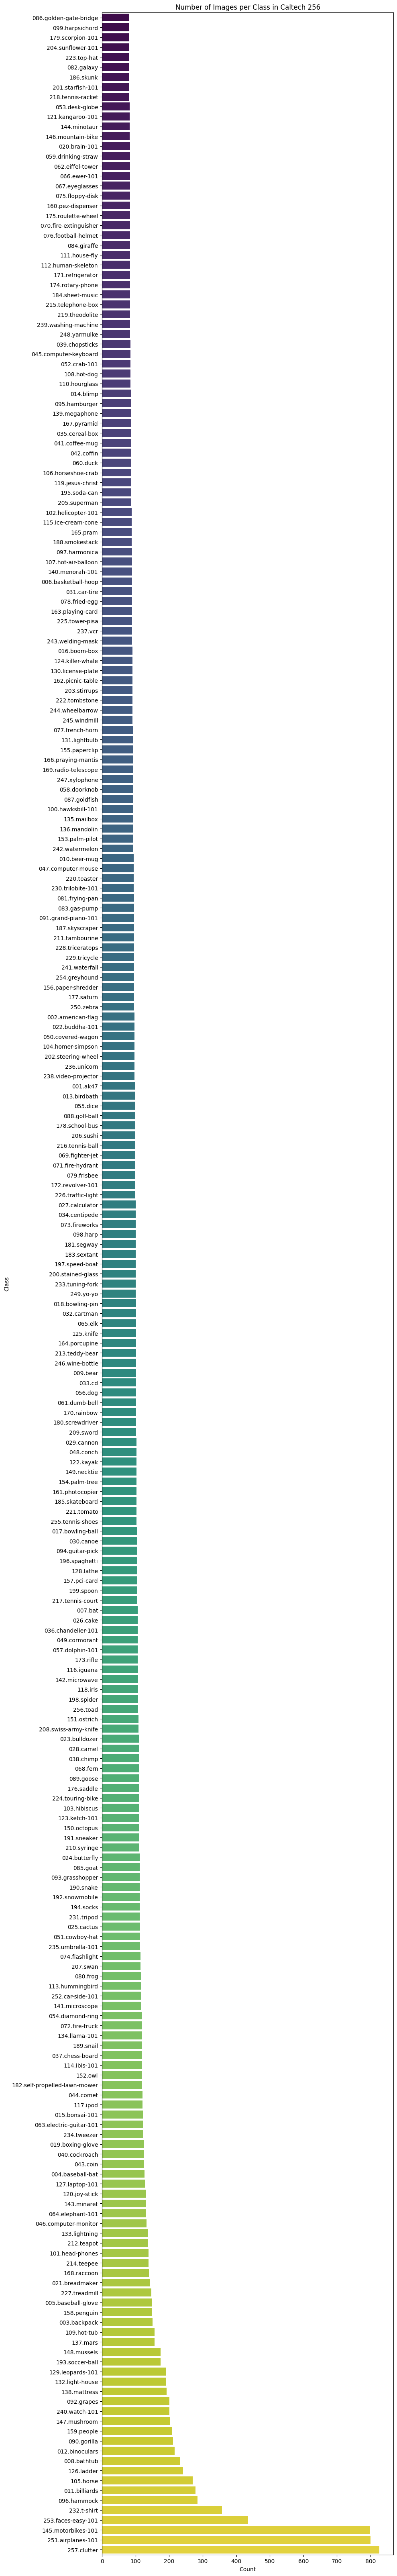

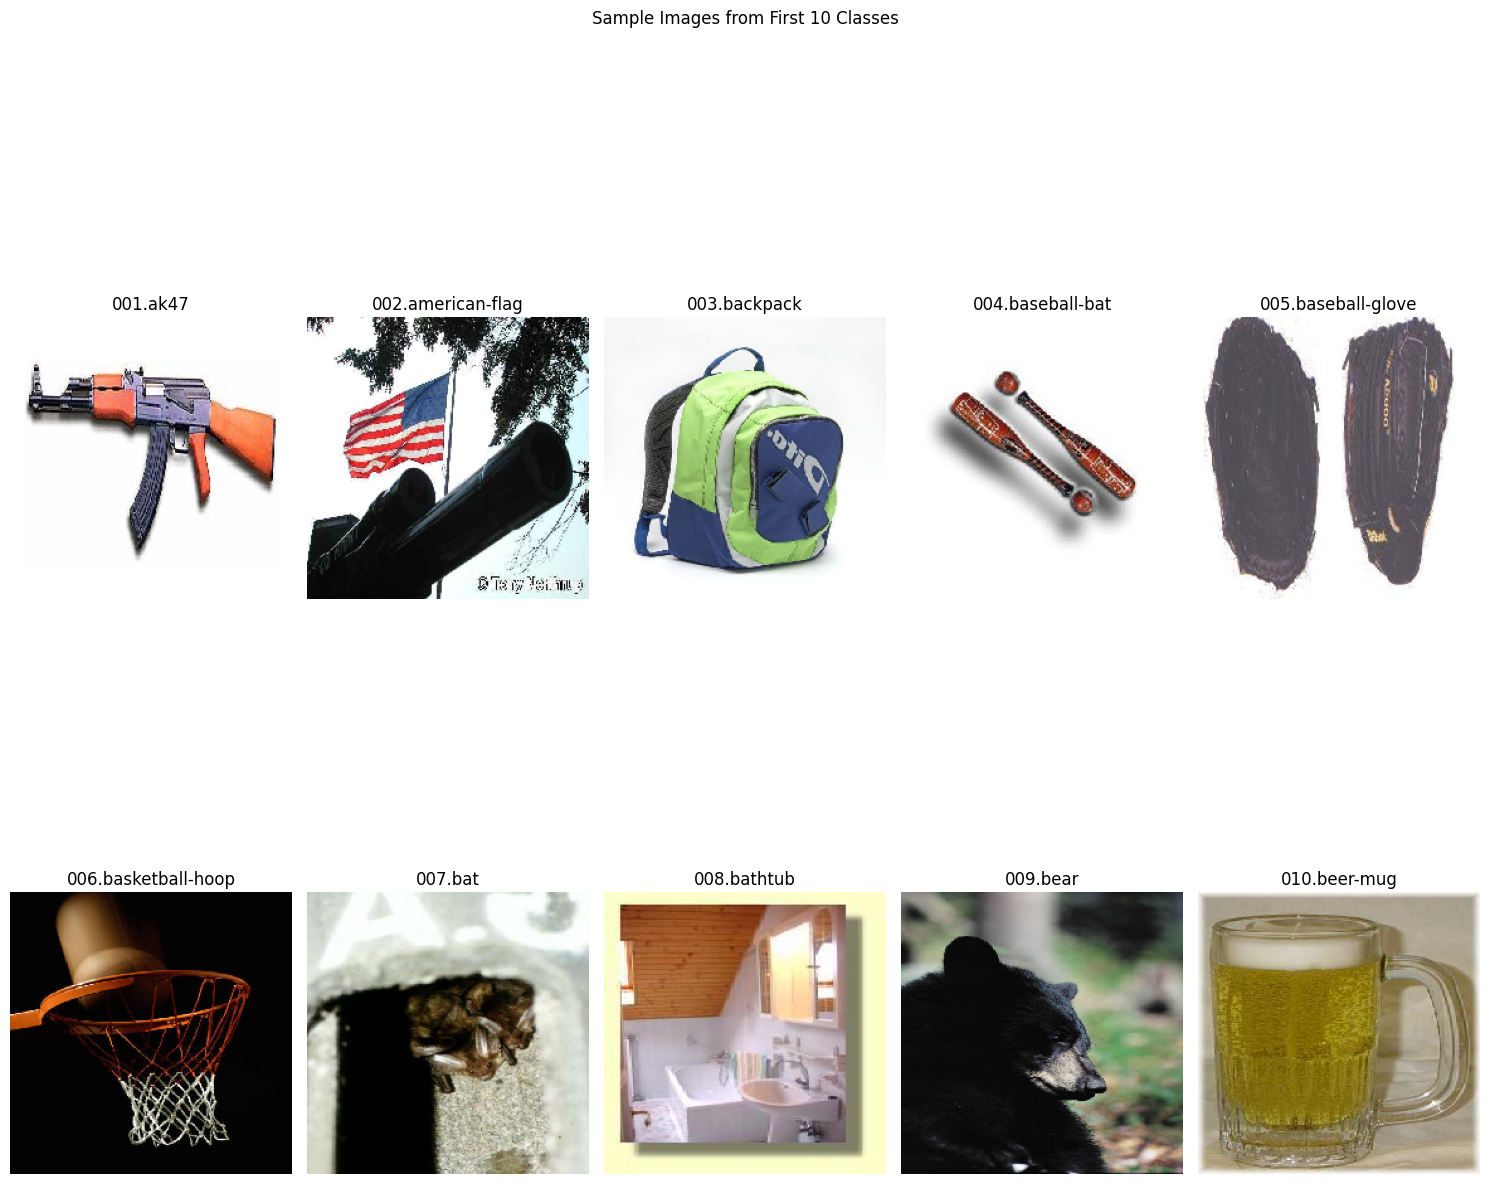

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

DATA_DIR = "/kaggle/input/caltech256/256_ObjectCategories"
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Total number of classes:", len(class_names))
print("Classes:", class_names)

class_counts = {}
for cls in class_names:
    cls_path = os.path.join(DATA_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

plt.figure(figsize=(10, len(class_names) * 0.25))
sorted_classes = sorted(class_counts, key=class_counts.get)
sorted_counts = [class_counts[cls] for cls in sorted_classes]
sns.barplot(x=sorted_counts, y=sorted_classes, palette="viridis")
plt.title("Number of Images per Class in Caltech 256")
plt.xlabel("Count")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 15))
for i, cls in enumerate(class_names[:10]):
    cls_path = os.path.join(DATA_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        img_path = os.path.join(cls_path, images[0])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
plt.suptitle("Sample Images from First 10 Classes")
plt.tight_layout()
plt.show()

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 24580 images belonging to 257 classes.
Found 6027 images belonging to 257 classes.


In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,082,881 (30.83 MB)

 Trainable params: 4,854,017 (18.52 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [4]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Computed Class Weights:", class_weights)

Computed Class Weights: {0: 1.2106585233709304, 1: 1.2261797864910706, 2: 0.7904299450107728, 3: 0.9376668955519951, 4: 0.8037144819017101, 5: 1.3283614353653264, 6: 1.1252002746623941, 7: 0.5142044265930296, 8: 1.166366138369555, 9: 1.2584476756092566, 10: 0.42888799706862557, 11: 0.5528440655855694, 12: 1.2106585233709304, 13: 1.3861162803812102, 14: 0.9759390137377908, 15: 1.3101647033740205, 16: 1.1385955160274226, 17: 1.1807657203247346, 18: 0.9564202334630351, 19: 1.4274928857657239, 20: 0.8389651170728377, 21: 1.2261797864910706, 22: 1.0868411743898125, 23: 1.0626891482922611, 24: 1.0395872102859076, 25: 1.1252002746623941, 26: 1.1955252918287937, 27: 1.0868411743898125, 28: 1.1523135342928132, 29: 1.1385955160274226, 30: 1.3283614353653264, 31: 1.1807657203247346, 32: 1.166366138369555, 33: 1.1955252918287937, 34: 1.3663146192329072, 35: 1.1252002746623941, 36: 0.9962710765239948, 37: 1.0868411743898125, 38: 1.4065003433279928, 39: 0.9564202334630351, 40: 1.3663146192329072, 41

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


769/769 ━━━━━━━━━━━━━━━━━━━━ 252s 317ms/step - accuracy: 0.2883 - loss: 3.8671 - val_accuracy: 0.6848 - val_loss: 1.2962
Epoch 2/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.7724 - loss: 0.9124 - val_accuracy: 0.7418 - val_loss: 1.0280
Epoch 3/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - accuracy: 0.8561 - loss: 0.5495 - val_accuracy: 0.7637 - val_loss: 0.9421
Epoch 4/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 75s 97ms/step - accuracy: 0.8995 - loss: 0.3678 - val_accuracy: 0.7797 - val_loss: 0.8730
Epoch 5/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.9389 - loss: 0.2228 - val_accuracy: 0.7684 - val_loss: 0.9389
Epoch 6/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9607 - loss: 0.1358 - val_accuracy: 0.7782 - val_loss: 0.9031
Epoch 7/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.9738 - loss: 0.0939 - val_accuracy: 0.7790 - val_loss: 0.9262
Epoch 8/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.9839 - loss: 0.0619 - val_accur

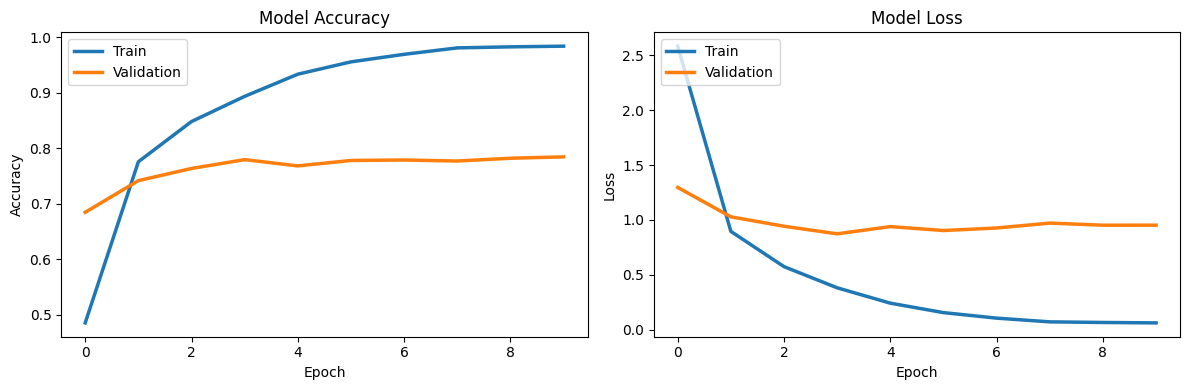

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], linewidth=2.5)
plt.plot(history.history['val_accuracy'], linewidth=2.5)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], linewidth=2.5)
plt.plot(history.history['val_loss'], linewidth=2.5)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
